> Introdução à Ciência dos Dados \
> Ciência da Computação – UFV/Florestal


* **Nome:** lucas takeshi, Jonathan Lopes, Matheus Silva
* **Matrícula:** 2665, 2666, 2649

----
# Importação dos Dados

**Etapa 1 - Escolha dos dados e planejamento**

In [2]:
#Importações de databases
#Etapa 1

!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_lobby_stats_player.csv
!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_medalha.csv
!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_players.csv
!wget https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_players_medalha.csv

--2022-07-23 16:37:14--  https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_lobby_stats_player.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28373607 (27M) [text/plain]
Saving to: ‘tb_lobby_stats_player.csv’

tb_lobby_stats_play 100%[===================>]  27.06M   144MB/s    in 0.2s    

2022-07-23 16:37:14 (144 MB/s) - ‘tb_lobby_stats_player.csv’ saved [28373607/28373607]

--2022-07-23 16:37:14--  https://raw.githubusercontent.com/LTaka/cs-go-csv/main/tb_medalha.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12

In [30]:
#importações das bibliotecas utilizadas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.linear_model import LinearRegression

**Etapa 2 - Preparação e análise exploratória dos dados**

In [4]:
original_df_lobby = pd.read_csv('./tb_lobby_stats_player.csv')
original_df_players = pd.read_csv('./tb_players.csv')
df_l =original_df_lobby
df_p =original_df_players
#Informações de players
#df_p.info()
#tratando os dados de players
df_p = df_p.drop("flFacebook",axis=1)
df_p = df_p.drop("flTwitter",axis=1)
df_p = df_p.drop("flTwitch",axis=1)
df_p = df_p.drop("dtBirth",axis=1)
df_p['dtRegistration'] = pd.to_datetime(df_p['dtRegistration'], infer_datetime_format=True)
df_l['qtSurvived'].fillna('drop', inplace=True)
#drop dos NAN
drop=df_l[df_l["qtSurvived"]=='drop'].index
df_l=df_l.drop(drop)
#Informações de players
#df_p.info()
#Informações de lobby
#df_l.info()
#tratando os dados de lobby
df_l = df_l.drop("qtShots",axis=1)
df_l = df_l.drop("qtPlusKill",axis=1)
df_l = df_l.drop("dtCreatedAt",axis=1)
df_l = df_l.drop("qtHitRightLeg",axis=1)
df_l = df_l.drop("qtHitLeftLeg",axis=1)
df_l = df_l.drop("qtHitRightArm",axis=1)
df_l = df_l.drop("qtHitLeftAtm",axis=1)
df_l = df_l.drop("qtHitStomach",axis=1)
df_l = df_l.drop("qtHitChest",axis=1)
df_l = df_l.drop("qtHitHeadshot",axis=1)
df_l = df_l.drop("qtTk",axis=1)
df_l = df_l.drop("qtTkAssist",axis=1)
#Informações de lobby
#df_l.info()
#criação de dados categóricos de acordo com cada parametro
#STATS na coluna de jogador junto com teste de hipotese para verificar se o player morre menos

In [5]:
#df_l.info()
#drop de rounds menores que o primeiro quartil para ter apenas players que jogaram uma quantidade consideravel de rounds
drop=df_l[df_l['qtRoundsPlayed']<df_l['qtRoundsPlayed'].quantile(0.25)].index
df_l=df_l.drop(drop)
df_l['qtRoundsPlayed'].describe()


count    146441.000000
mean         28.358691
std           4.582400
min          23.000000
25%          25.000000
50%          28.000000
75%          30.000000
max          84.000000
Name: qtRoundsPlayed, dtype: float64

In [28]:
# Calcular kill por round
def kpr(kills, rounds):
  kpr = kills/rounds #quanto mais alto melhor 
  return kpr

def dpr(deaths, rounds): #quanto mais próximo de 0 melhor
  dpr = deaths/rounds
  return dpr

#qtAssist - 15, qtBombePlant - 15, qtBombeDefuse - 20, qtClutchWon - 20, qtTrade - 10, qtFlashAssist - 10, qtFirstKill - 10
def distPoints(qtAssist, qtBombePlant, qtBombeDefuse, qtClutchWon, qtTrade, qtFlashAssist, qtFirstKill):
  qtAssist = qtAssist*15
  qtBombePlant = qtBombePlant*15
  qtBombeDefuse = qtBombeDefuse*20
  qtClutchWon = qtClutchWon*20
  qtTrade = qtTrade*10
  qtFlashAssist = qtFlashAssist*10
  qtFirstKill = qtFirstKill*10
  total = (qtAssist+qtBombePlant+qtBombeDefuse+qtClutchWon+qtTrade+qtFlashAssist+qtFirstKill)/7
  
  return total

df_l.insert((df_l.shape[1]),"kpr",kpr(df_l['qtKill'], df_l['qtRoundsPlayed']),True) #Kills Per Round
df_l.insert((df_l.shape[1]),"dpr",dpr(df_l['qtDeath'], df_l['qtRoundsPlayed']),True) #Deaths Per Round
df_l.insert((df_l.shape[1]),"pps",distPoints(df_l['qtAssist'], df_l['qtBombePlant'], df_l['qtBombeDefuse'], df_l['qtClutchWon'], df_l['qtTrade'], df_l['qtFlashAssist'], df_l['qtFirstKill']),True) #Points Per Stats
df_l.insert((df_l.shape[1]),"playerQuality",'Null',True) #Player Quality
df_l

def regressao_linear(X,Y,cols):

  if len(cols) == 1:
    X = X.values.reshape(-1,1)

  lm = LinearRegression()
  lm.fit(X,Y)
  print('Coeficiente estimado: ', lm.coef_)    
  print('R2 (score): ', lm.score(X,Y))
  print("Intercept %.3f " % lm.intercept_)

  coeff_df = pd.DataFrame(lm.coef_, cols, columns=['Coefficient'])
  print(coeff_df)


In [7]:
def playerQuality(df):
  for i in df.index:
    if (df['pps'][i] <= 20.0):
      df['playerQuality'][i] = 'Ruim'
    elif ((df['pps'][i] > 20.0)&(df['pps'][i] <= 40.0)):
      df['playerQuality'][i] = 'Regular'
    elif ((df['pps'][i] > 40.0)&(df['pps'][i] <= 60.0)):
      df['playerQuality'][i] = 'Bom'
    elif ((df['pps'][i] > 60.0)&(df['pps'][i] <= 80.0)):
      df['playerQuality'][i] = 'Muito Bom'
    elif (df['pps'][i] > 80.0):
      df['playerQuality'][i] = 'Excelente'

In [8]:
playerQuality(df_l)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: Sett

In [ ]:
df_l['playerQuality'].value_counts()

Regular      88040
Ruim         52934
Bom           5350
Muito Bom      114
Excelente        3
Name: playerQuality, dtype: int64

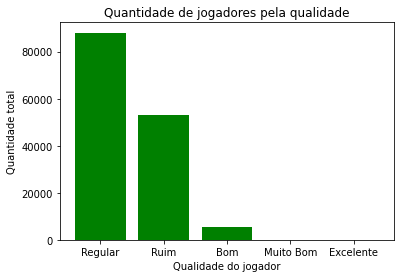

In [ ]:
plt.bar(df_l['playerQuality'].unique(),df_l['playerQuality'].value_counts(), color='green')
plt.ylabel('Quantidade total')
plt.xlabel('Qualidade do jogador')
plt.title('Quantidade de jogadores pela qualidade')
plt.show()

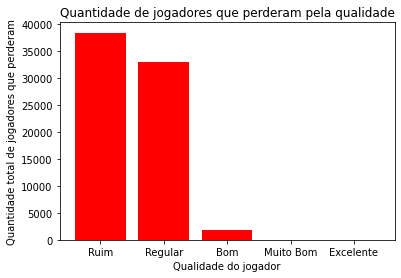

In [11]:
playersLosers = df_l[df_l["flWinner"]==0]
plt.bar(playersLosers['playerQuality'].unique(),playersLosers['playerQuality'].value_counts(), color='red')
plt.ylabel('Quantidade total de jogadores que perderam')
plt.xlabel('Qualidade do jogador')
plt.title('Quantidade de jogadores que perderam pela qualidade')
plt.show()

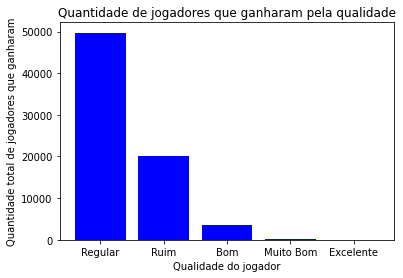

In [12]:
playersWinners = df_l[df_l["flWinner"]==1]
plt.bar(playersWinners['playerQuality'].unique(),playersWinners['playerQuality'].value_counts(), color='blue')
plt.ylabel('Quantidade total de jogadores que ganharam')
plt.xlabel('Qualidade do jogador')
plt.title('Quantidade de jogadores que ganharam pela qualidade')
plt.show()

In [13]:
playersLosers['playerQuality'].value_counts()

Regular      38329
Ruim         32925
Bom           1902
Muito Bom       41
Excelente        2
Name: playerQuality, dtype: int64

In [14]:
playersWinners['playerQuality'].value_counts()

Regular      49711
Ruim         20009
Bom           3448
Muito Bom       73
Excelente        1
Name: playerQuality, dtype: int64

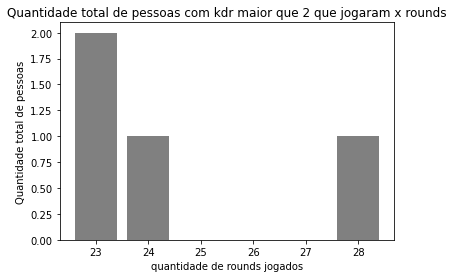

In [15]:
vg = df_l[df_l['kpr']>=2]
plt.bar(vg['qtRoundsPlayed'].unique(), vg['qtRoundsPlayed'].value_counts(), color='gray')
plt.ylabel('Quantidade total de pessoas')
plt.xlabel('quantidade de rounds jogados')
plt.title('Quantidade total de pessoas com kdr maior que 2 que jogaram x rounds')
plt.show()

In [16]:
df_l['qtRoundsPlayed'].describe()
#usar 1 quartil como separador deixando como minimo 23 rounds para se avaliar um jogador

count    146441.000000
mean         28.358691
std           4.582400
min          23.000000
25%          25.000000
50%          28.000000
75%          30.000000
max          84.000000
Name: qtRoundsPlayed, dtype: float64

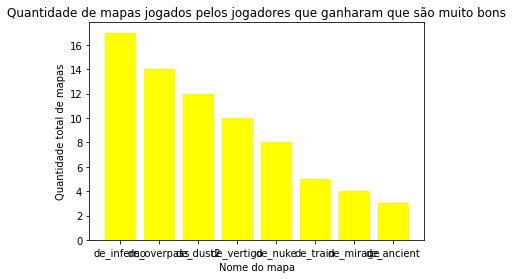

In [17]:
vgpw = playersWinners[playersWinners['playerQuality']=='Muito Bom']
plt.bar(vgpw['descMapName'].unique(), vgpw['descMapName'].value_counts(), color='yellow')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que ganharam que são muito bons')
plt.show()

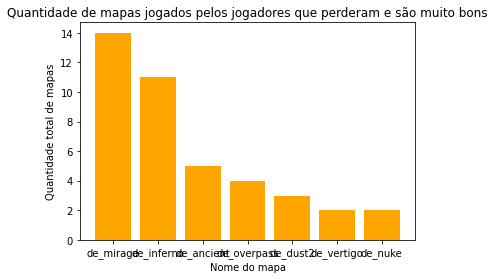

In [18]:
vgpl = playersLosers[playersLosers['playerQuality']=='Muito Bom']
plt.bar(vgpl['descMapName'].unique(), vgpl['descMapName'].value_counts(), color='orange')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que perderam e são muito bons')
plt.show()

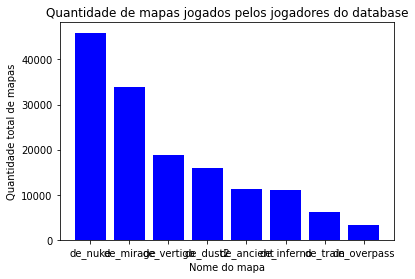

In [19]:
plt.bar(df_l['descMapName'].unique(), df_l['descMapName'].value_counts(), color='blue')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores do database')
plt.show()

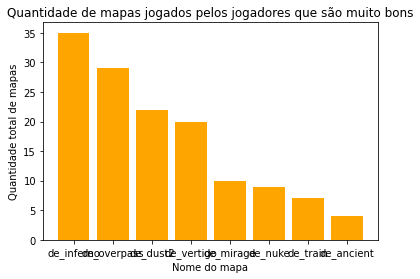

In [20]:
vgp = df_l[df_l['pps']>=60]
plt.bar(vgp['descMapName'].unique(), vgp['descMapName'].value_counts(), color='orange')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que são muito bons')
plt.show()
#jogadores com qualidade alta tendem a jogar mais inferno -> Over -> dust2 -> vertigo -> Mirage -> Nuke -> Train -> Ancient

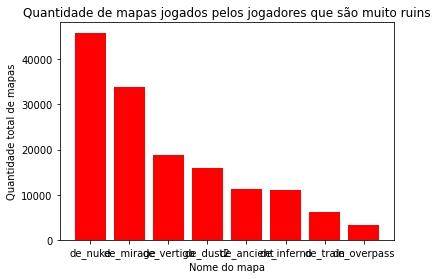

In [21]:
vgp = df_l[df_l['pps']<=60]
plt.bar(vgp['descMapName'].unique(), vgp['descMapName'].value_counts(), color='red')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de mapas jogados pelos jogadores que são muito ruins')
plt.show()

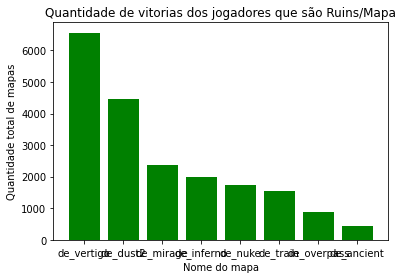

In [22]:
vgpl = playersWinners[playersWinners['playerQuality']=='Ruim']
plt.bar(vgpl['descMapName'].unique(), vgpl['descMapName'].value_counts(), color='Green')
plt.ylabel('Quantidade total de mapas')
plt.xlabel('Nome do mapa')
plt.title('Quantidade de vitorias dos jogadores que são Ruins/Mapa')
plt.show()
#Nuke, o mapa que eles mais jogam, é o terceiro mapa que ele menos ganham.

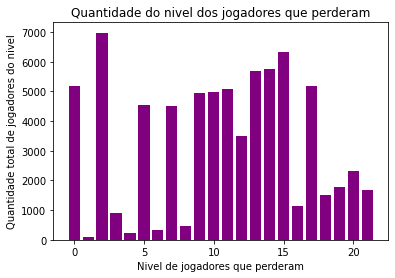

In [ ]:
plt.bar(playersLosers['vlLevel'].unique(), playersLosers['vlLevel'].value_counts(), color='purple')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores que perderam')
plt.show()

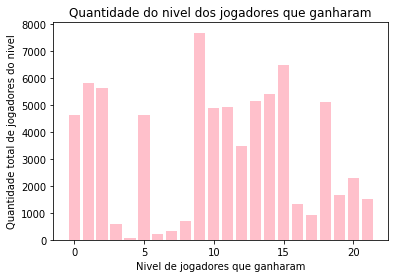

In [ ]:
plt.bar(playersWinners['vlLevel'].unique(), playersWinners['vlLevel'].value_counts(), color='pink')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que ganharam')
plt.title('Quantidade do nivel dos jogadores que ganharam')
plt.show()

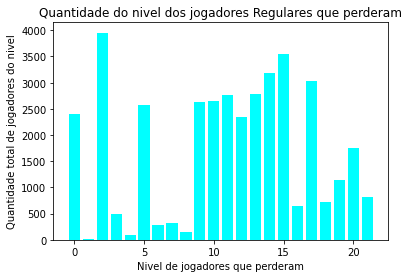

In [ ]:
rpl = playersLosers[playersLosers['playerQuality']=='Regular']
plt.bar(rpl['vlLevel'].unique(), rpl['vlLevel'].value_counts(), color='cyan')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores Regulares que perderam')
plt.show()

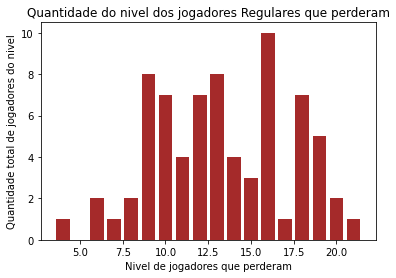

In [ ]:
rpl = playersWinners[playersWinners['playerQuality']=='Muito Bom']
plt.bar(rpl['vlLevel'].unique(), rpl['vlLevel'].value_counts(), color='brown')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Quantidade do nivel dos jogadores Regulares que perderam')
plt.show()

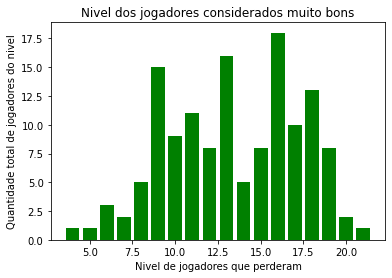

In [ ]:
rpl = df_l[df_l['pps']>=60]
plt.bar(rpl['vlLevel'].unique(), rpl['vlLevel'].value_counts(), color='green')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Nivel dos jogadores considerados muito bons')
plt.show()

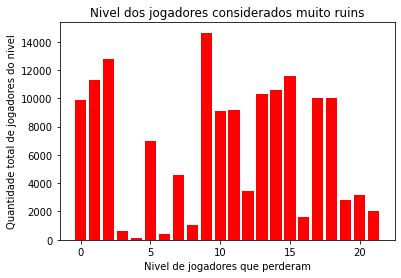

In [ ]:
rpl = df_l[df_l['pps']<=60]
plt.bar(rpl['vlLevel'].unique(), rpl['vlLevel'].value_counts(), color='red')
plt.ylabel('Quantidade total de jogadores do nivel')
plt.xlabel('Nivel de jogadores que perderam')
plt.title('Nivel dos jogadores considerados muito ruins')
plt.show()

In [ ]:
df_l['pps'].describe()

count    146441.000000
mean         23.866106
std           8.441323
min           0.000000
25%          17.857143
50%          22.857143
75%          29.285714
max          90.714286
Name: pps, dtype: float64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'kpr por mapa')

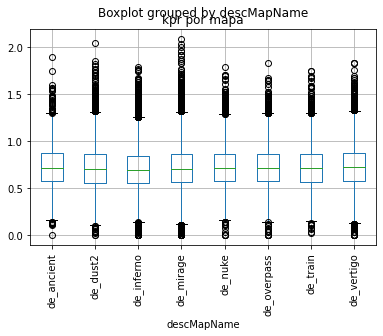

In [ ]:
killPorMapa = df_l.boxplot(column='kpr',by="descMapName", rot =90)
killPorMapa.set_title("kpr por mapa")
#inconclusivo por enquanto, pois o mapa que tem mais kills também é o mapa mais jogado
#isso deve ser calculado com base na media de kills por partida 

In [ ]:
x = df_l.groupby('descMapName')
y = x['qtKill'].count()
x['qtKill'].describe()
#MEDIA DE KILLS POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,3387.0,20.859463,7.154590,0.0,16.0,20.0,25.0,61.0
de_dust2,18761.0,20.382282,7.161748,0.0,15.0,20.0,25.0,85.0
de_inferno,33851.0,20.092878,6.847048,0.0,15.0,19.0,24.0,70.0
de_mirage,45901.0,20.548093,7.164280,0.0,16.0,20.0,25.0,73.0
de_nuke,11211.0,20.731514,7.000101,0.0,16.0,20.0,25.0,60.0
de_overpass,11156.0,20.740498,6.976928,0.0,16.0,20.0,25.0,67.0
de_train,6168.0,20.541180,7.106518,1.0,16.0,20.0,25.0,68.0
de_vertigo,16006.0,20.820317,7.143809,0.0,16.0,20.0,25.0,63.0


In [ ]:
x = df_l.groupby('descMapName')
y = x['qtClutchWon'].count()
x['qtClutchWon'].describe()
#MEDIA DE CLUTCH POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,3387.0,0.536758,0.756967,0.0,0.0,0.0,1.0,6.0
de_dust2,18761.0,0.501626,0.733896,0.0,0.0,0.0,1.0,5.0
de_inferno,33851.0,0.473634,0.711443,0.0,0.0,0.0,1.0,8.0
de_mirage,45901.0,0.501514,0.731625,0.0,0.0,0.0,1.0,6.0
de_nuke,11211.0,0.535545,0.763378,0.0,0.0,0.0,1.0,7.0
de_overpass,11156.0,0.524919,0.748168,0.0,0.0,0.0,1.0,6.0
de_train,6168.0,0.513619,0.739102,0.0,0.0,0.0,1.0,5.0
de_vertigo,16006.0,0.544546,0.766029,0.0,0.0,0.0,1.0,8.0


In [ ]:
x = df_l.groupby('descMapName')
y = x['kpr'].count()
x['kpr'].describe()

#MEDIA DE KPR POR MAPA

,count,mean,std,min,25%,50%,75%,max
descMapName,,,,,,,,
de_ancient,3387.0,0.733093,0.222566,0.000000,0.583333,0.720000,0.870953,1.888889
de_dust2,18761.0,0.719231,0.225644,0.000000,0.560000,0.703704,0.862069,2.043478
de_inferno,33851.0,0.707766,0.215367,0.000000,0.560000,0.695652,0.840000,1.791667
de_mirage,45901.0,0.725325,0.226108,0.000000,0.566667,0.708333,0.866667,2.083333
de_nuke,11211.0,0.730884,0.219042,0.000000,0.583333,0.720000,0.866667,1.791667
de_overpass,11156.0,0.729719,0.217298,0.000000,0.576923,0.720000,0.866667,1.833333
de_train,6168.0,0.725963,0.223969,0.027778,0.571429,0.714286,0.862069,1.750000
de_vertigo,16006.0,0.734101,0.222927,0.000000,0.576923,0.722222,0.875000,1.827586


In [ ]:
kill = df_l.qtKill.sum() #quantidade de kills do DataBase
flash = df_l.qtFlashAssist.sum()

flash/kill #porcentagem de kills que tiveram auxilio de flashs
#aproximadamente 2% das kills apenas tem assistencia de flashs

0.02992931984727354

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'Kpr por qualidade de player')

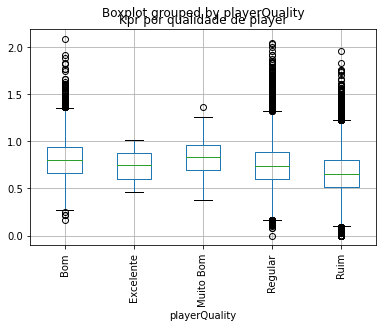

In [ ]:
killPorQualidade = df_l.boxplot(column='kpr',by="playerQuality", rot =90)
killPorQualidade.set_title("Kpr por qualidade de player")

In [ ]:
win = df_l['flWinner']>0
win.value_counts()

True     73242
False    73199
Name: flWinner, dtype: int64

In [ ]:
a = df_l[['dpr', 'qtSurvived']]
b = df_l[['vlDamage', 'qtKill']]

In [ ]:
a.corr()

,dpr
dpr,1.0


In [ ]:
b.corr()

,vlDamage,qtKill
vlDamage,1.000000,0.948241
qtKill,0.948241,1.000000


In [ ]:
df_l['qtHs'].describe()

count    146441.000000
mean          8.148005
std           4.008621
min           0.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          41.000000
Name: qtHs, dtype: float64

In [ ]:
# Calcular %hs
def phs(qtHs, kills):
  phs = qtHs/kills #quanto mais alto melhor
  return phs

In [ ]:
df_l.insert((df_l.shape[1]),"phs",phs(df_l['qtHs'], df_l['qtKill']),True)#Percentual de kills por hs (headshot)

In [ ]:
df_l['phs'].describe()

count    1.463920e+05
mean              inf
std               NaN
min      0.000000e+00
25%      3.000000e-01
50%      3.913043e-01
75%      5.000000e-01
max               inf
Name: phs, dtype: float64

In [ ]:
phs = df_l[df_l['phs']> 0.5]
phs['phs'].describe()

count    2.966000e+04
mean              inf
std               NaN
min      5.087719e-01
25%      5.416667e-01
50%      5.789474e-01
75%      6.363636e-01
max               inf
Name: phs, dtype: float64

In [ ]:
#para se colocar alguma afirmação deve saber pela quantidade de rounds jogados? Podemos considerar que a partir de uma quantidade minima de rounds para entrar no calculo? partidas muito longas podem ser retiradas?
df_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146441 entries, 1 to 184150
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   idLobbyGame     146441 non-null  int64  
 1   idPlayer        146441 non-null  int64  
 2   idRoom          146441 non-null  int64  
 3   qtKill          146441 non-null  int64  
 4   qtAssist        146441 non-null  int64  
 5   qtDeath         146441 non-null  int64  
 6   qtHs            146441 non-null  int64  
 7   qtBombeDefuse   146441 non-null  int64  
 8   qtBombePlant    146441 non-null  int64  
 9   qt1Kill         146441 non-null  int64  
 10  qt2Kill         146441 non-null  int64  
 11  qt3Kill         146441 non-null  int64  
 12  qt4Kill         146441 non-null  int64  
 13  qt5Kill         146441 non-null  int64  
 14  qtFirstKill     146441 non-null  int64  
 15  vlDamage        146441 non-null  int64  
 16  qtHits          146441 non-null  float64
 17  qtLastAliv

In [ ]:
#regras de associação
#kpr < 0.5 - ruim, Kpr>=0.5 < 1.0 - regular, 1-1.3 bom; 1.3-1.5 - muito bom; 1.5 - excelente
bins = [0, 0.5, 1, 1.3, 1.5, np.inf]
names = ['Ruim', 'Regular', 'Bom', 'Muito Bom', 'Excelente']
df_l['kpr_categoric'] = pd.cut(df_l['kpr'], bins, labels=names)

In [ ]:
filter = df_l[df_l['kpr']>1.3]
#filter
filter[['kpr','kpr_categoric']]

,kpr,kpr_categoric
37,1.333333,Muito Bom
251,1.400000,Muito Bom
271,1.586207,Excelente
352,1.333333,Muito Bom
387,1.333333,Muito Bom
...,...,...
182858,1.333333,Muito Bom
183675,1.360000,Muito Bom
183690,1.392857,Muito Bom
183737,1.379310,Muito Bom


In [ ]:
#dpr 0:0.2 - Excelente, 0.2:0.4 - Muito bom, 0.4:0.6 - Bom; 0.6:0.8 - Regular; 0.8 - Ruim
bins = [0, 0.2, 0.4, 0.6, 0.8, np.inf]
names = ['Excelente', 'Muito Bom', 'Bom', 'Regular', 'Ruim']
df_l['dpr_categoric'] = pd.cut(df_l['dpr'], bins, labels=names)

In [ ]:
filter = df_l[df_l['dpr']<=0.3]
#filter
filter[['dpr','dpr_categoric']]

,dpr,dpr_categoric
1448,0.275862,Muito Bom
3056,0.142857,Excelente
7272,0.260870,Muito Bom
7497,0.148148,Excelente
7588,0.296296,Muito Bom
...,...,...
181915,0.076923,Excelente
182026,0.260870,Muito Bom
182925,0.173913,Excelente
183492,0.233333,Muito Bom


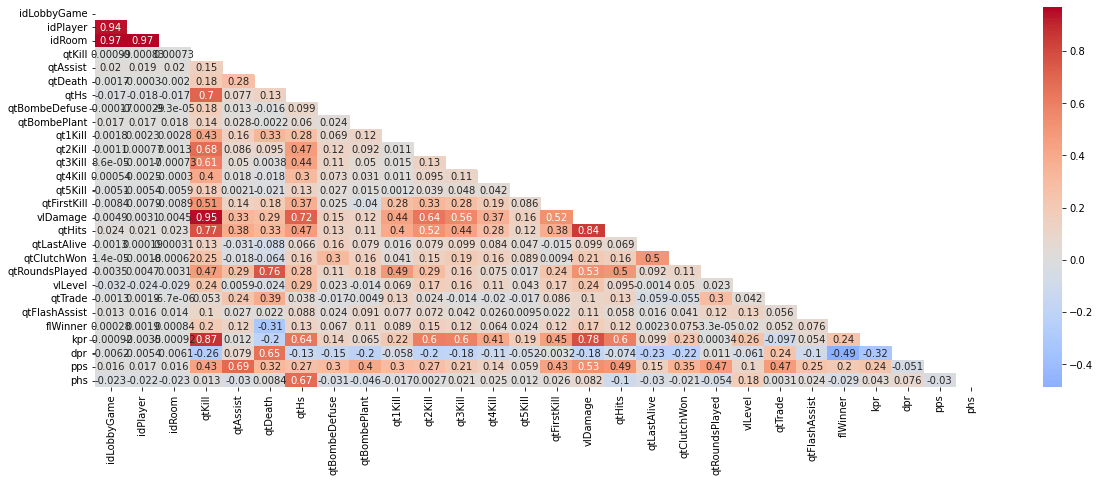

In [ ]:
Var_Corr = df_l.corr()
matrix = np.triu(df_l.corr())

plt.figure(figsize = (20,7))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns,\
            annot=True,center= 0, cmap= 'coolwarm',mask=matrix)

In [ ]:
df_rules = df_l[['kpr_categoric','dpr_categoric','playerQuality','descMapName', 'flWinner']]
df_rules.head()

,kpr_categoric,dpr_categoric,playerQuality,descMapName,flWinner
1,Regular,Regular,Regular,de_nuke,1
2,Ruim,Ruim,Ruim,de_mirage,0
3,Ruim,Regular,Regular,de_mirage,1
4,Ruim,Ruim,Regular,de_nuke,0
11,Regular,Regular,Ruim,de_mirage,0


In [ ]:
df_transactions = pd.get_dummies(df_rules)
#df_transactions = df_rules
#df_transactions = pd.get_dummies(df_transactions, columns=['kpr_categoric'])
#df_transactions = pd.get_dummies(df_transactions, columns=['dpr_categoric'])
#df_transactions = pd.get_dummies(df_transactions, columns=['playerQuality'])
#df_transactions = pd.get_dummies(df_transactions, columns=['descMapName'])

In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146441 entries, 1 to 184150
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   flWinner                 146441 non-null  int64
 1   kpr_categoric_Ruim       146441 non-null  uint8
 2   kpr_categoric_Regular    146441 non-null  uint8
 3   kpr_categoric_Bom        146441 non-null  uint8
 4   kpr_categoric_Muito Bom  146441 non-null  uint8
 5   kpr_categoric_Excelente  146441 non-null  uint8
 6   dpr_categoric_Excelente  146441 non-null  uint8
 7   dpr_categoric_Muito Bom  146441 non-null  uint8
 8   dpr_categoric_Bom        146441 non-null  uint8
 9   dpr_categoric_Regular    146441 non-null  uint8
 10  dpr_categoric_Ruim       146441 non-null  uint8
 11  playerQuality_Bom        146441 non-null  uint8
 12  playerQuality_Excelente  146441 non-null  uint8
 13  playerQuality_Muito Bom  146441 non-null  uint8
 14  playerQuality_Regular    146441 non-

In [ ]:
#Erro pois não tem apenas 0 ou 1
frequent_itemsets = apriori(df_transactions, min_support=0.3, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.500147,(flWinner)
1,0.740312,(kpr_categoric_Regular)
2,0.673561,(dpr_categoric_Regular)
3,0.601198,(playerQuality_Regular)
4,0.361470,(playerQuality_Ruim)
5,0.313444,(descMapName_de_mirage)
6,0.378221,"(kpr_categoric_Regular, flWinner)"
7,0.341926,"(dpr_categoric_Regular, flWinner)"
8,0.339461,"(playerQuality_Regular, flWinner)"
9,0.518297,"(kpr_categoric_Regular, dpr_categoric_Regular)"


In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
rules.sort_values(by="confidence",ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,"(dpr_categoric_Regular, playerQuality_Regular)",(kpr_categoric_Regular),0.418503,0.740312,0.328200,0.784225,1.059317,0.018378,1.203513
7,(dpr_categoric_Regular),(kpr_categoric_Regular),0.673561,0.740312,0.518297,0.769488,1.039411,0.019652,1.126572
9,(playerQuality_Regular),(kpr_categoric_Regular),0.601198,0.740312,0.456996,0.760143,1.026788,0.011923,1.082680
1,(flWinner),(kpr_categoric_Regular),0.500147,0.740312,0.378221,0.756219,1.021487,0.007956,1.065252
13,"(kpr_categoric_Regular, playerQuality_Regular)",(dpr_categoric_Regular),0.456996,0.673561,0.328200,0.718169,1.066226,0.020385,1.158276


In [ ]:
cols_interesse = ['kpr_categoric_Ruim','kpr_categoric_Regular','kpr_categoric_Bom','kpr_categoric_Muito Bom','kpr_categoric_Excelente  ',
                  'dpr_categoric_Ruim','dpr_categoric_Regular','dpr_categoric_Bom','dpr_categoric_Muito Bom','dpr_categoric_Excelente  ',
                  'playerQuality_Bom', 'playerQuality_Muito Bom', 'playerQuality_Regular', 'playerQuality_Ruim', 'playerQuality_Excelente',
                  'descMapName_de_ancient', 'descMapName_de_dust2', 'descMapName_de_inferno', 'descMapName_de_mirage', 'descMapName_de_nuke',
                  'descMapName_de_overpass', 'descMapName_de_train', 'descMapName_de_vertigo'
                  ]


In [24]:
df = pd.get_dummies(df_l, columns=["playerQuality"])

In [25]:
cols_interesse = ['qtKill','qtDeath','vlDamage','qtClutchWon','vlLevel','qtHs','qt5Kill','kpr','dpr','pps','playerQuality_Bom','playerQuality_Excelente','playerQuality_Muito Bom','playerQuality_Regular','playerQuality_Ruim','phs']
target = 'flWinner'

In [26]:
cols_interesse_all = cols_interesse.copy()
cols_interesse_all.append(target)

In [31]:
X = df['qtKill']
Y = df[target]
regressao_linear(X,Y,['qtKill'])

Coeficiente estimado:  [0.01427239]
R2 (score):  0.04066337337629933
Intercept 0.208 
        Coefficient
qtKill     0.014272


In [32]:
X = df['kpr']
Y = df[target]
regressao_linear(X,Y,['kpr'])

Coeficiente estimado:  [0.54598149]
R2 (score):  0.058794559783095335
Intercept 0.106 
     Coefficient
kpr     0.545981


In [33]:
X = df['pps']
Y = df[target]
regressao_linear(X,Y,['pps'])

Coeficiente estimado:  [0.01208665]
R2 (score):  0.041638017753107825
Intercept 0.212 
     Coefficient
pps     0.012087


In [ ]:
cols_interesse_all = cols_interesse.copy()
cols_interesse_all
# df_transactions[cols_interesse_all]
#df_l
#df_transactions
#sns.pairplot(df_l)